# 전통적 시계열 모델링

   ## 유통매장 수요량 예측

* 비즈니스 현황
    * 고객사는 A 유통회사의 a 매장 입니다.
    * a 매장에서 주력상품인 a01에 대한 재고 최적화를 위해 수요량을 예측하고자 합니다.
    * 최근 경쟁사의 매장이 가까운 거리에 오픈하였고, 유사한 상품에 대한 공격적인 마케팅을 펼치고 있습니다. 
* 발주 최적화를 위한 수요량 예측 : 1일후의 판매량을 예측

![](https://www.artefact.com//wp-content/uploads/2021/08/GettyImages-1295864156-scaled.jpg)

# 1.환경 준비

## (1) Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import * 


import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

## (2) Data Loading

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/retail_demand2.csv'
data = pd.read_csv(path)
data = data.loc[(data['date']>= '2013-06-01') & (data['date']< '2015-03-01')].reset_index(drop = True)
data.head(10)

,date,item,sales,tot_sales,comp_sales
0,2013-06-01,28,124,1016,80
1,2013-06-02,28,139,1019,93
2,2013-06-03,28,77,676,65
3,2013-06-04,28,93,764,80
4,2013-06-05,28,117,818,80
5,2013-06-06,28,112,881,71
6,2013-06-07,28,127,929,81
7,2013-06-08,28,105,925,78
8,2013-06-09,28,129,998,95
9,2013-06-10,28,103,710,74


* 변수 설명

    * date : 날짜
    * item : 상품코드 (여기서는 한가지 상품만 있음)
    * sales : A유통회사 a 매장 판매량 ==> target
    * tot_sales : A유통회사 전체 판매량
    * comp_sales : 인근에 위치한 B유통회사 b 매장 판매량

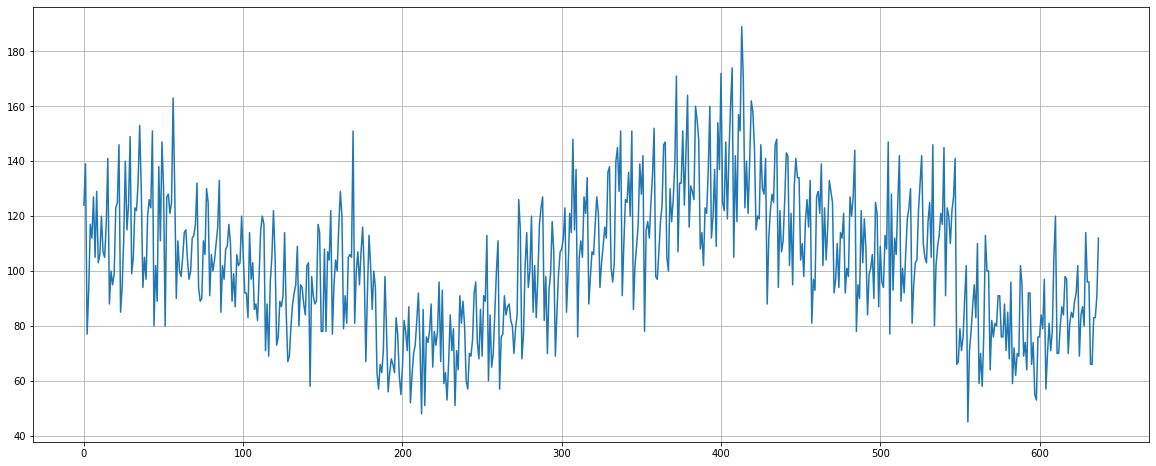

In [3]:
plt.figure(figsize = (20,8))
plt.plot(data['sales'])
plt.grid()
plt.show()

## (3) 함수 생성 

* 결과 시각화

In [4]:
def plot_model_result(y_train, y_val, pred) :
    pred = pd.Series(pred, index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

* 잔차분석

In [5]:
def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

# 2.기본 전처리

## (1) y 만들기

* 사전 관찰(look-ahead) : 미래의 어떤 사실을 안다는 뜻
* 사전 관찰 문제 : 
    * 데이터를 통해 실제로 알아야 하는 시점보다 더 일찍 미래에 대한 사실을 알게 되는 문제.  
    * 사전관찰 문제가 있는 채로 모델링을 하게 되면, 놀라운 성능의 모델이 만들어짐. --> 그러나 실제로는 불가능한 상황.

* 그래서 y를 만들때 사전관찰문제가 발생되지 않도록 해야 함.
    * 예제는 1일 후의 수요량을 예측하려고 합니다.

* 1일 후 수요량을 예측하려면, y를 어떻게 만들어야 할까요?

In [6]:
data['y'] = data['sales'].shift(-1)
display(data.head())
display(data.tail())

,date,item,sales,tot_sales,comp_sales,y
0,2013-06-01,28,124,1016,80,139.0
1,2013-06-02,28,139,1019,93,77.0
2,2013-06-03,28,77,676,65,93.0
3,2013-06-04,28,93,764,80,117.0
4,2013-06-05,28,117,818,80,112.0


,date,item,sales,tot_sales,comp_sales,y
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,83.0
635,2015-02-26,28,83,611,48,91.0
636,2015-02-27,28,91,696,74,112.0
637,2015-02-28,28,112,774,77,NaN


In [7]:
# 제일 마지막 행은 삭제
data.dropna(axis = 0, inplace = True)
data.tail()

,date,item,sales,tot_sales,comp_sales,y
632,2015-02-23,28,66,488,43,66.0
633,2015-02-24,28,66,603,71,83.0
634,2015-02-25,28,83,622,61,83.0
635,2015-02-26,28,83,611,48,91.0
636,2015-02-27,28,91,696,74,112.0


## (2) 데이터 분할

### 1) x, y 나누기

In [8]:
target = 'y'

x = data.drop([target, 'date'], axis = 1) #제거할 때, date도 제거
y = data.loc[:, target]

### 2) train, val 분할
* 1회 분할 : train_test_split( x, y, test_size= , shuffle = False) 
    * test_size : 소수 - 비율, 자연수 - 갯수
    * shuffle = False : 섞지 말고 데이터 끝에서 test_size 만큼 자르기
* k-fold cross validation for Time Seires : TimeSeriesSplit

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 30, shuffle = False)

# 3.시계열모델링① : ML 기반 모델링

## (1) 모델링

In [11]:
m1 = LinearRegression()
m1.fit(x_train, y_train)

LinearRegression()

## (2) 검증

In [12]:
p1 = m1.predict(x_val)

print('RMSE : ', mean_squared_error(y_val, p1, squared = False))
print('MAE  : ', mean_absolute_error(y_val, p1))
print('MAPE : ', mean_absolute_percentage_error(y_val, p1))

RMSE :  15.03863560317514
MAE  :  10.344670568255443
MAPE :  0.1265099070302173


## (3) 결과 시각화

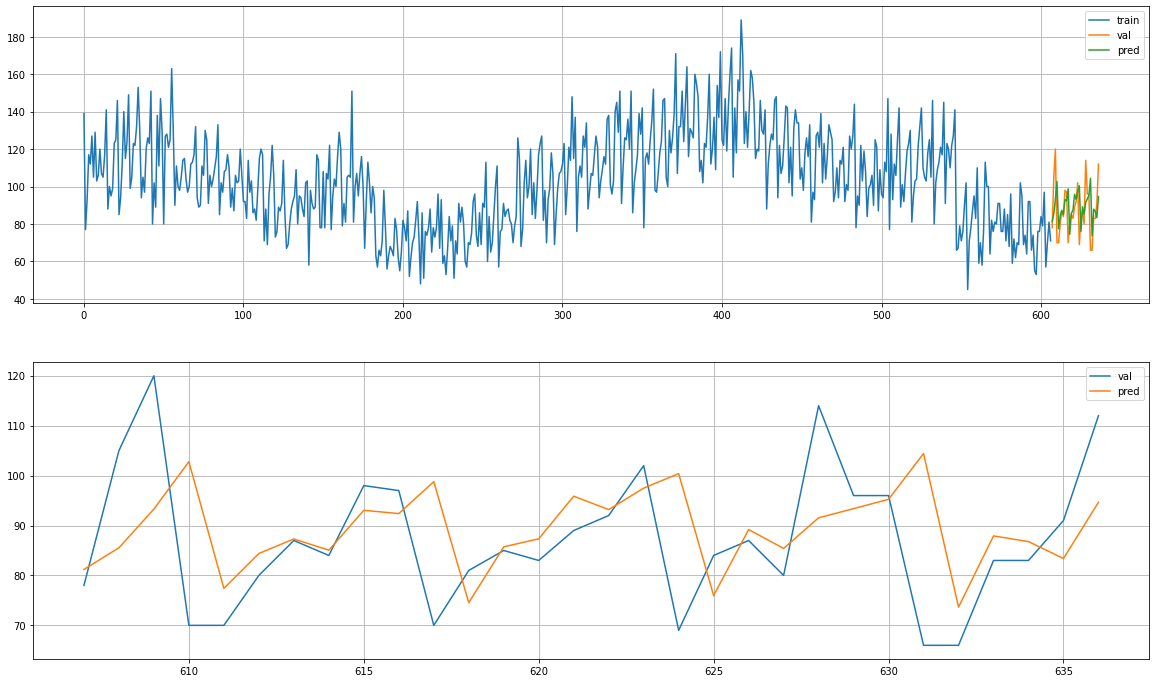

In [13]:
plot_model_result(y_train, y_val, p1)

# 4.시계열모델링② : 전통적 시계열 모델링

## (1) 모델링
* 일단 모델링을 해 봅시다.
* order=(p,d,q) : p,d,q 숫자는 아무것이나 넣어도 됩니다. 0~4 사이의 숫자들.


In [14]:
m2 = sm.tsa.SARIMAX(y_train, order=(4,1,4)).fit()

## (2) 검증

In [15]:
p2 = m2.forecast(30) # train 이후 30일 데이터 예측

print('RMSE : ', mean_squared_error(y_val, p2, squared = False))
print('MAE  : ', mean_absolute_error(y_val, p2))
print('MAPE : ', mean_absolute_percentage_error(y_val, p2))

RMSE :  14.00232028577849
MAE  :  11.204982332385974
MAPE :  0.12062722914998032


## (3) 결과 시각화

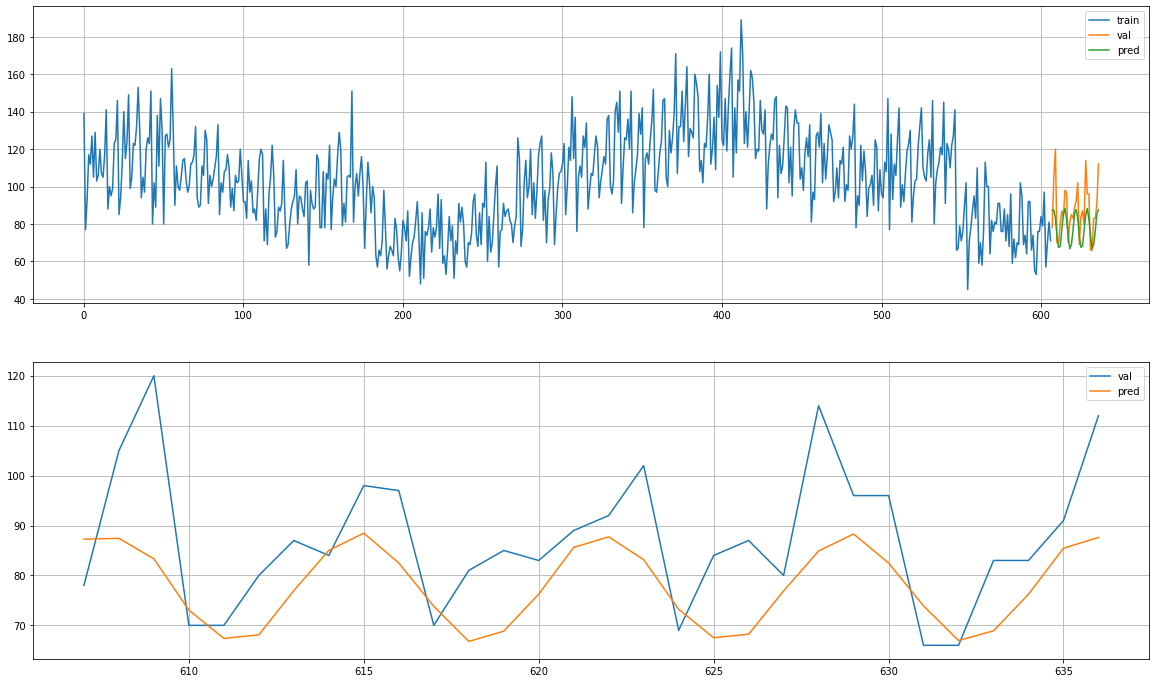

In [16]:
plot_model_result(y_train, y_val, p2)

# 5.평가 : 잔차분석

In [17]:
residuals = m2.resid

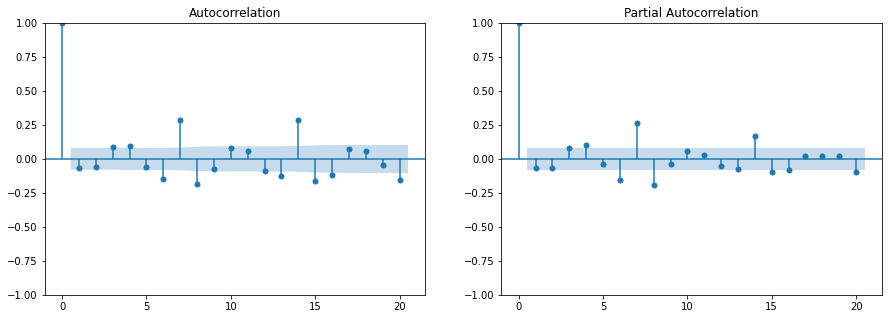

In [18]:
lags = 20

fig,ax = plt.subplots(1,2, figsize = (15,5))
plot_acf(residuals, lags = lags, ax = ax[0])
plot_pacf(residuals, lags = lags, ax = ax[1])
plt.show()

In [19]:
spst.shapiro(residuals)[1]

1.0285748083338833e-14

In [20]:
sm.tsa.stattools.adfuller(residuals)[1]

2.0054694639427048e-07